In [1]:
import os
import numpy as np
from glob import glob
import pandas as pd

import scipy.misc
import scipy.io 
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
from sklearn.preprocessing import OneHotEncoder

In [3]:
import keras

Using TensorFlow backend.


In [6]:
img = scipy.misc.imread("data/train/000002.jpg", mode="RGB")

In [7]:
img.shape

(751, 500, 3)

In [8]:
img.resize()

In [9]:
!ls data/ClothingAttributeDataset/labels/

black_GT.mat	 many_colors_GT.mat	  placket_GT.mat
blue_GT.mat	 neckline_GT.mat	  purple_GT.mat
brown_GT.mat	 necktie_GT.mat		  red_GT.mat
category_GT.mat  pattern_floral_GT.mat	  scarf_GT.mat
collar_GT.mat	 pattern_graphics_GT.mat  skin_exposure_GT.mat
cyan_GT.mat	 pattern_plaid_GT.mat	  sleevelength_GT.mat
gender_GT.mat	 pattern_solid_GT.mat	  white_GT.mat
gray_GT.mat	 pattern_spot_GT.mat	  yellow_GT.mat
green_GT.mat	 pattern_stripe_GT.mat


In [4]:
def combine_labels(LABEL_DIR):
    dfs = []
    for label_file in glob(os.path.join(LABEL_DIR, "*.mat")):
        feature_name = label_file.split("/")[-1].split(".")[0]
        values = (scipy.io.loadmat(label_file)["GT"] - 1)
        feat_df = pd.DataFrame(data=values, index=np.arange(1, len(values)+1), columns=[feature_name])
        dfs.append(feat_df)
    labels_df = pd.concat(dfs, axis=1)
    labels_df["image"] = labels_df.index.map(lambda val: "{:06d}.jpg".format(val))
    return labels_df

In [5]:
LABEL_DIR = "data/ClothingAttributeDataset/labels/"
labels_df = combine_labels(LABEL_DIR)
labels_df.to_csv("data/labels.csv", index=False)

In [6]:
labels_df = pd.read_csv("data/labels.csv", index_col="image")
labels_df.head()

,white_GT,skin_exposure_GT,pattern_spot_GT,pattern_solid_GT,neckline_GT,collar_GT,yellow_GT,many_colors_GT,gray_GT,pattern_graphics_GT,...,necktie_GT,blue_GT,pattern_stripe_GT,pattern_floral_GT,brown_GT,red_GT,cyan_GT,placket_GT,black_GT,purple_GT
image,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0.0,0.0,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0
000002.jpg,0.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,1.0,0.0,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0
000003.jpg,0.0,0.0,0.0,1.0,NaN,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
000004.jpg,0.0,0.0,0.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
000005.jpg,1.0,1.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Missing Value Counts
# (labels_df == 0).sum(axis=0).sort_values(ascending=False)
# pd.isnull(labels_df).sum(axis=0)
(labels_df == 0.5).sum(axis=0).sort_values(ascending=False)

category_GT            752
neckline_GT            542
collar_GT              394
pattern_solid_GT       363
scarf_GT               190
pattern_stripe_GT      182
skin_exposure_GT       166
pattern_floral_GT      138
pattern_spot_GT        136
necktie_GT             117
pattern_plaid_GT       116
gray_GT                112
yellow_GT              112
many_colors_GT         112
purple_GT              112
black_GT               112
green_GT               112
blue_GT                112
brown_GT               112
red_GT                 112
cyan_GT                112
white_GT               112
pattern_graphics_GT     78
sleevelength_GT         75
placket_GT              73
gender_GT               62
dtype: int64

In [9]:
labels_df.columns

Index(['white_GT', 'skin_exposure_GT', 'pattern_spot_GT', 'pattern_solid_GT',
       'neckline_GT', 'collar_GT', 'yellow_GT', 'many_colors_GT', 'gray_GT',
       'pattern_graphics_GT', 'sleevelength_GT', 'gender_GT', 'scarf_GT',
       'category_GT', 'pattern_plaid_GT', 'green_GT', 'necktie_GT', 'blue_GT',
       'pattern_stripe_GT', 'pattern_floral_GT', 'brown_GT', 'red_GT',
       'cyan_GT', 'placket_GT', 'black_GT', 'purple_GT'],
      dtype='object')

In [7]:
TARGET_CLASSES = {column: 1 for column in labels_df.columns}
TARGET_CLASSES["category_GT"] = 7
TARGET_CLASSES["neckline_GT"] = 3
TARGET_CLASSES["sleevelength_GT"] = 3

In [8]:
target_columns = [column for column in labels_df.columns 
                  if column not in ["category_GT", "sleevelength_GT", "neckline_GT"]]

In [9]:
LABEL_VALUES = {
    "sleevelength_GT": {
        0: "No sleeves",
        1: "Short sleeves",
        2: "Long sleeves"
    },
    "category_GT": {
        0: "Shirt",
        1: "Sweater", 
        2: "T-shirt",
        3: "Outerwear",
        4: "Suit",
        5: "Tank Top",
        6: "Dress"
    },
}

In [10]:
def make_dataset(images_folder, labels_file, target_columns, target_img_size=(400, 266), onehot=True):
    # Load Labels file
    labels_df = pd.read_csv(labels_file, index_col="image")
    X = []
    y = []
    for image_file in glob(os.path.join(images_folder, "*.jpg")):
        filename = image_file.split("/")[-1]
        y_val = [labels_df.loc[filename, target_col] for target_col in target_columns]

        img_array = scipy.misc.imread(image_file, mode="RGB")
        img_array = scipy.misc.imresize(img_array, target_img_size)
        y.append(y_val)
        X.append(img_array)
    
    X = np.array(X)
    y = np.array(y).astype(int)
    
    return X, y

In [11]:
def get_data(images_folder, labels_file, feat_name, target_img_size=(400, 266), onehot=True):
    # Load Labels file
    labels_df = pd.read_csv(labels_file, index_col="image")
    X = []
    y = []
    for image_file in glob(os.path.join(images_folder, "*.jpg")):
        filename = image_file.split("/")[-1]
        try:
            label_val = labels_df.loc[filename, feat_name]
            if pd.isnull(label_val):
                # Feature Value is not defined, so continue to next image
                continue
            label_val = int(label_val)
        except KeyError:
            # Filename not found
            print(filename)
            continue
        img_array = scipy.misc.imread(image_file, mode="RGB")
        img_array = scipy.misc.imresize(img_array, target_img_size)
        y.append(label_val)
        X.append(img_array)
    
    X = np.array(X)
    y = np.array(y).astype(int)
    
    return X, y

## Data Loaded.  Build the Model

In [12]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.models import Model, Sequential, Input
from keras.layers import Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout, Flatten, Dense, Activation
from keras import backend as K

from keras.preprocessing import image
from keras.optimizers import Adam, RMSprop

In [13]:
from imagenet_dl_models.keras.vgg16 import preprocess_input_vgg

In [14]:
train_datagen = image.ImageDataGenerator(
        preprocessing_function=preprocess_input_vgg,
#         zca_whitening=True,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False  # randomly flip images
    )
valid_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
test_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input_vgg)

In [15]:
# batch_size = 32
# epochs=10
# train_steps_per_epoch = len(X_train) // batch_size
# valid_steps_per_epoch = len(X_valid) // batch_size

# train_genarator = train_datagen.flow(X_train, Y_train, batch_size=batch_size, shuffle=True)
# valid_generator = valid_datagen.flow(X_valid, Y_valid, batch_size=batch_size, shuffle=False)
# test_generator = test_datagen.flow(X_test, Y_test, batch_size=batch_size, shuffle=False)

In [16]:
vgg_conv_model = VGG16(weights='imagenet', include_top=False, input_shape=(400, 266, 3))

In [17]:
def add_bn_layers(inp_layer, dropout_p, output_dims=3, activation="softmax"):
    
    print(inp_layer)
    inp_layer = MaxPooling2D()(inp_layer)
    inp_layer = BatchNormalization(axis=1)(inp_layer)
    inp_layer = Flatten()(inp_layer)

    # Add FC Layer 1
#     dropout_1 = Dropout(dropout_p/4)(bn_1)
    dense_1 = Dense(1024)(inp_layer)
    dense_1 = BatchNormalization()(dense_1)
    dense_1 = Activation("relu")(dense_1)

    dense_2 = Dense(512)(dense_1)
    dense_2 = BatchNormalization()(dense_2)
    dense_2 = Activation("relu")(dense_2)

#     # Add FC Layer 2
#     bn_2 = BatchNormalization()(dense_1)
#     dropout_2 = Dropout(dropout_p/2)(bn_2)
#     dense_2 = Dense(512, activation="relu")(dropout_2)

    # Add Final Output Layer
#     bn_3 = BatchNormalization()(dense_2)
    dropout_3 = Dropout(dropout_p)(dense_2)
    output_layer = Dense(output_dims, activation=activation)(dropout_3)
    
    return output_layer

In [18]:
for layer in vgg_conv_model.layers:
    layer.trainable = False
    
nb_output_dims = len(target_columns)
vgg_last_conv_layer = vgg_conv_model.get_layer("block5_conv3")
output_layer = add_bn_layers(vgg_last_conv_layer.output,
               dropout_p=0.9, 
               output_dims=nb_output_dims)

vgg_conv_model = Model(inputs=vgg_conv_model.inputs, outputs=output_layer)

Tensor("block5_conv3/Relu:0", shape=(?, 25, 16, 512), dtype=float32)


In [19]:
vgg_conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 266, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 266, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 266, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 133, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 133, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 133, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 66, 128)      0         
__________

In [20]:
y_train

NameError: name 'y_train' is not defined

In [ ]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=len(X_valid), shuffle=False)
#     test_generator = test_datagen.flow(X_test, Y_test, batch_size=len(X_test), shuffle=False)

for epoch, (X, y) in enumerate(train_generator):
    X_vgg_output = vgg_conv_model.predict(X)
    hist = model.fit(X_vgg_output, y, batch_size=len(X), epochs=1, verbose=0) 
    if epoch > nb_epochs:
        break
    if epoch % 5  == 0:
        X_vgg_output = vgg_conv_model.predict_generator(valid_generator, steps=1)
        valid_result = model.evaluate_generator(X_vgg_output, y_valid)
        print(epoch, valid_result)


In [19]:
# resnet_model = ResNet50(include_top=False, weights="imagenet", input_shape=(400, 266, 3))

In [21]:
def basic_cnn_model(input_shape, num_classes=3):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [22]:
m1 = basic_cnn_model((400, 266, 3), num_classes=7)

In [42]:
def get_bn_layers(p, input_shape, output_dims=3, optimizer="rmsprop", metrics=["accuracy"]):
    model = Sequential([
        MaxPooling2D(input_shape=input_shape),
#         BatchNormalization(axis=1),
#         Dropout(p/4),
        Flatten(),
#         Dense(512, activation='relu'),
#         BatchNormalization(),
#         Dropout(p/2),
#         Dense(512, activation='relu'),
#         BatchNormalization(),
#         Dropout(p),
        Dense(output_dims)
    ])
    if output_dims == 1:
        model.add(Activation("sigmoid"))
        loss = "binary_crossentropy"
    else:
        model.add(Activation("softmax"))
        loss = "categorical_crossentropy"
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [43]:
vgg_last_conv_layer = vgg_conv_model.get_layer("block5_conv3")
vgg_conv_model = Model(inputs=vgg_conv_model.inputs, outputs=vgg_last_conv_layer.output)
# sleve_length_layer = add_bn_layers(vgg_last_conv_layer_output,
#                                    dropout_p=0.9, 
#                                    output_dims=7)

In [65]:
vgg_conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 266, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 266, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 266, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 133, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 133, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 133, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 66, 128)      0         
__________

In [44]:
TARGET_CLASSES["category_GT"] = 7
TARGET_CLASSES["neckline_GT"] = 3
TARGET_CLASSES["sleevelength_GT"] = 3

In [45]:
model_input_shape

[25, 16, 512]

In [59]:
vgg_last_conv_layer.output.shape[1:]

TensorShape([Dimension(25), Dimension(16), Dimension(512)])

In [55]:
model_input_shape

[25, 16, 512]

In [62]:
# Create a Tuple of Model Shape
model_input_shape = [int(item) for item in vgg_last_conv_layer.output.shape[1:]]
# model_input_shape = (25, 16, 512)
models = {}
p = 0

for target, count in TARGET_CLASSES.items():
    if target in ["sleevelength_GT", "category_GT"]:
        models[target] = get_bn_layers(p=p, input_shape=model_input_shape, output_dims=count)

In [63]:
models["sleevelength_GT"].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_12 (MaxPooling (None, 12, 8, 512)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 49152)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 147459    
_________________________________________________________________
activation_13 (Activation)   (None, 3)                 0         
Total params: 147,459.0
Trainable params: 147,459.0
Non-trainable params: 0.0
_________________________________________________________________


In [48]:
LABELS_FILE = "data/labels.csv"
TRAIN_IMAGES_FOLDER = "data/train/"
VALID_IMAGES_FOLDER = "data/valid/"
TEST_IMAGES_FOLDER = "data/test/"

In [49]:
X_vgg_output.shape

(256, 25, 16, 512)

In [64]:
y_train

array([[ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [68]:
X_vgg_output.shape

(256, 25, 16, 512)

In [69]:
y.shape

(256, 3)

In [ ]:
## Load Data and Train Model
for target, model in models.items():

    batch_size = 256
    nb_epochs = 1

    # Convert y_vect values to one hot vector
    # Traning Data
    X_train, y_train = get_data(TRAIN_IMAGES_FOLDER, LABELS_FILE, target)
    X_valid, y_valid = get_data(VALID_IMAGES_FOLDER, LABELS_FILE, target)

    nb_classes = TARGET_CLASSES[target]
    if nb_classes > 1:
        y_train = keras.utils.to_categorical(y_train, nb_classes)
        y_valid = keras.utils.to_categorical(y_valid, nb_classes)
    
#     # Test Data
#     X_test, y_test_vect = get_data(TEST_IMAGES_FOLDER, LABELS_FILE, target)
#     Y_test = keras.utils.to_categorical(y_test_vect, nb_classes)
    
    train_steps_per_epoch = len(X_train) // batch_size
    valid_steps_per_epoch = len(X_valid) // batch_size

    train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
    valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=len(X_valid), shuffle=False)
#     test_generator = test_datagen.flow(X_test, Y_test, batch_size=len(X_test), shuffle=False)
    
    for epoch, (X, y) in enumerate(train_generator):
        X_vgg_output = vgg_conv_model.predict(X)
        hist = model.fit(X_vgg_output, y, batch_size=len(X), epochs=1, verbose=0) 
        if epoch > nb_epochs:
            break
        if epoch % 5  == 0:
            X_vgg_output = vgg_conv_model.predict_generator(valid_generator, steps=1)
            valid_result = model.evaluate_generator(X_vgg_output, y_valid)
            print(epoch, valid_result)
    
    
#     # fits the model on batches with real-time data augmentation:
#     hist1 = models[target].fit(X_vgg_output,
#                         steps_per_epoch=train_steps_per_epoch,
#                         epochs=1,
#                        validation_data=valid_generator,
#                        validation_steps=valid_steps_per_epoch)

In [ ]:
vgg_conv_model.fit()

In [69]:
_ = models["sleevelength_GT"].fit(X_vgg_output, Y_train)

ValueError: Input arrays should have the same number of samples as target arrays. Found 1024 input samples and 1424 target samples.

In [21]:
print("Train: ", (X_train.shape, Y_train.shape))
print("Validation: ", (X_valid.shape, Y_valid.shape))
print("Test: ", (X_test.shape, Y_test.shape))

Train:  ((1424, 400, 266, 3), (1424, 3))
Validation:  ((178, 400, 266, 3), (178, 3))
Test:  ((179, 400, 266, 3), (179, 3))


In [26]:
# model = Model(inputs=vgg_conv_model.inputs, outputs=sleve_length_layer)

In [29]:
# fits the model on batches with real-time data augmentation:
hist1 = m1.fit_generator(train_genarator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=1,
                   validation_data=valid_generator,
                   validation_steps=valid_steps_per_epoch)

Epoch 1/1
27/27 [==============================] - 19s - loss: 12.2585 - acc: 0.2350 - val_loss: 12.9281 - val_acc: 0.1979

In [30]:
model.optimizer.lr = 0.01
# fits the model on batches with real-time data augmentation:
hist2 = m1.fit_generator(train_genarator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=3,
                   validation_data=valid_generator,
                   validation_steps=valid_steps_per_epoch)

Epoch 1/3
27/27 [==============================] - 19s - loss: 12.3230 - acc: 0.2355 - val_loss: 12.3373 - val_acc: 0.2346

In [31]:
model.optimizer.lr = 1e-4
# fits the model on batches with real-time data augmentation:
hist3 = m1.fit_generator(train_genarator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=10,
                   validation_data=valid_generator,
                   validation_steps=valid_steps_per_epoch)

Epoch 1/10
27/27 [==============================] - 17s - loss: 12.2938 - acc: 0.2373 - val_loss: 12.7353 - val_acc: 0.2099

In [32]:
# fits the model on batches with real-time data augmentation:
hist1 = model.fit_generator(train_genarator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=1,
                   validation_data=valid_generator,
                   validation_steps=valid_steps_per_epoch)

Epoch 1/1
27/27 [==============================] - 19s - loss: 3.9946 - acc: 0.1891 - val_loss: 2.1322 - val_acc: 0.5309

In [33]:
model.optimizer.lr = 0.01
# fits the model on batches with real-time data augmentation:
hist2 = model.fit_generator(train_genarator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=3,
                   validation_data=valid_generator,
                   validation_steps=valid_steps_per_epoch)

Epoch 1/3
27/27 [==============================] - 18s - loss: 2.9919 - acc: 0.3038 - val_loss: 1.9796 - val_acc: 0.4815

In [34]:
model.optimizer.lr = 1e-4
# fits the model on batches with real-time data augmentation:
hist3 = model.fit_generator(train_genarator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=10,
                   validation_data=valid_generator,
                   validation_steps=valid_steps_per_epoch)

Epoch 1/10
27/27 [==============================] - 21s - loss: 2.1856 - acc: 0.4278 - val_loss: 1.4011 - val_acc: 0.6420

KeyboardInterrupt: 

In [115]:
train_loss = hist1.history["loss"] + hist2.history["loss"] + hist3.history["loss"]
val_loss = hist1.history["val_loss"] + hist2.history["val_loss"] + hist3.history["val_loss"]

In [116]:
train_acc = hist1.history["acc"] + hist2.history["acc"] + hist3.history["acc"]
val_acc = hist1.history["val_acc"] + hist2.history["val_acc"] + hist3.history["val_acc"]

In [117]:
hist1.history

{'acc': [0.31541218639773139],
 'loss': [3.2052436775061679],
 'val_acc': [0.5061728453930513],
 'val_loss': [5.863925203864957]}

(0.5, 1)

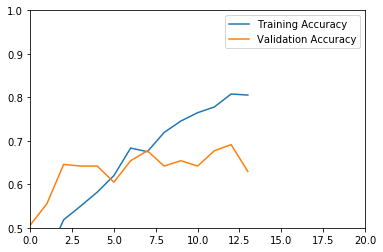

In [118]:
plt.plot(range(len(train_acc)), train_acc, label="Training Accuracy")
ax = plt.plot(range(len(train_acc)), val_acc, label="Validation Accuracy")
plt.legend(loc="best")
plt.xlim([0, 20])
plt.ylim([0.5, 1])

(0, 1.5)

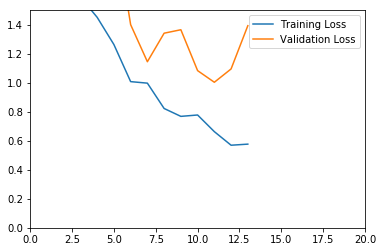

In [119]:
plt.plot(range(len(train_loss)), train_loss, label="Training Loss")
ax = plt.plot(range(len(train_loss)), val_loss, label="Validation Loss")
plt.legend(loc="best")
plt.xlim([0, 20])
plt.ylim([0, 1.5])

In [102]:
y_pred = model.predict(X_test)

In [103]:
y_pred_val = np.argmax(y_pred, axis=1)
y_true_val = np.argmax(Y_test, axis=1)

In [104]:
(y_true_val == y_pred_val).sum()

74

In [105]:
len(y_pred_val)

122

In [106]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true_val, y_pred_val)

array([[ 2,  1,  0,  4,  2,  0,  4],
       [ 1,  0,  1,  2,  1,  2,  2],
       [ 0,  0, 11,  0,  0,  0,  0],
       [ 1,  1,  0, 10,  3,  0,  5],
       [ 0,  0,  0,  5, 25,  1,  0],
       [ 0,  0,  0,  0,  1,  2,  3],
       [ 1,  0,  0,  4,  0,  3, 24]])

In [107]:
74/112

0.6607142857142857

In [78]:
!mkdir models

In [81]:
model.evaluate_generator(valid_generator, steps=len(X_valid)//valid_generator.batch_size)

[0.43782301545143126, 0.89375000000000004]

In [80]:
model.evaluate_generator(test_generator, steps=len(X_test)//test_generator.batch_size)

[0.64593856036663055, 0.875]

## Save Model

In [128]:
!ls data/

ClothingAttributeDataset      labels.csv  train
ClothingAttributeDataset.zip  test	  valid


In [77]:
model.save_weights("weights/slevelength_1.h5")

## Test Model

In [123]:
from PIL import Image
import requests
from io import BytesIO

import numpy as np
from keras.applications.vgg16 import preprocess_input

url = "https://developer.clarifai.com/static/images/model-samples/apparel-002.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img_array = np.array(img)
img_array = scipy.misc.imresize(img, (400, 266, 3)).astype("float")

X = np.expand_dims(img_array, axis=0)
X = preprocess_input(X)

In [101]:
import numpy as np
from keras.applications.vgg16 import preprocess_input

# img = scipy.misc.imread("data/train/000002.jpg", mode="RGB")
img_array = scipy.misc.imresize(img, (400, 266, 3)).astype(float)

X = np.expand_dims(img_array, axis=0)
X = preprocess_input(X)

In [102]:
# img = scipy.misc.imread("data/train/000002.jpg", mode="RGB")
# img_array = scipy.misc.imresize(img, (400, 266, 3))
# img_array[:,:,0] -= 103.939
# img_array[:,:,1] -= 116.779
# img_array[:,:,2] -= 123.68
# img_array = np.expand_dims(img_array, 0)

In [124]:
model.predict(X)

array([[ 0.00366195,  0.40545434,  0.59088367]], dtype=float32)